<a href="https://colab.research.google.com/github/acevedosharp/ensemble-testing-chamber/blob/master/notebooks/ensemble_classifier_combination_tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measuring the effectiveness of ensembles

- assemble all possible combination of ensembles $k \in \{1,2,3,4,5\}$
- 10-fold cross validation


## Experimental setup

In [2]:
import itertools
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# classifiers
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# datasets
from sklearn.datasets import *

from datetime import datetime

In [6]:
# Running the experiments with the 4 datasets at the same time might take longer than 1.5h (bad for Colab) so we can run both separately and join them later
ds_names = [
            "Breast Cancer",
            "Digits",
            "Wine"
]

datasets = [
            sklearn.datasets.load_breast_cancer(return_X_y=True),
            sklearn.datasets.load_digits(return_X_y=True),
            sklearn.datasets.load_wine(return_X_y=True)
]

### Execute experiments

In [10]:
classifiers = {
    "Linear SVC": LinearSVC(),
    "Decission Tree": DecisionTreeClassifier(),
    "Extra Tree": ExtraTreeClassifier(),
    "Logistic": LogisticRegression(),
    "Passive Aggressive": PassiveAggressiveClassifier(),
    "Perceptron": Perceptron(),
    "Ridge": RidgeClassifier(),
    "SGD": SGDClassifier(),
    "Multi-layer Perceptron": MLPClassifier(),
    "Linear Discriminant": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant": QuadraticDiscriminantAnalysis(),
    "BernoulliNB": BernoulliNB(),
    "MultinomialNB": MultinomialNB(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Random Forest (10 estimators)": RandomForestClassifier(n_estimators=10),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [ ]:
results = []

kf = KFold(n_splits=10)
for ds_idx, ds in enumerate(datasets):
  X, Y = ds[0], ds[1]
  #X = StandardScaler().fit_transform(X)
  fold_index = 0
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index] # np.take
    Y_train, Y_test = Y[train_index], Y[test_index] # np.take

    # Train every classifier with the new data
    for classifier_name, classifier in classifiers.items():
      classifier.fit(X_train, Y_train)
    # Assemble ensembles of size k in {1,2,3,4,5}
    for k in range(1,6):
      for combination in list(itertools.combinations(classifiers.keys(), k)):
        ensemble = []
        ensemble_description = ""

        # group classifiers (already exist fitted in dict)
        for idx in range(k):
          ensemble.append(classifiers[combination[idx]])
          ensemble_description += combination[idx]
          ensemble_description += "-"
        ensemble_description = ensemble_description[:-1]

        # save predictions
        predictions = np.zeros((len(X_test), k)) # (# test instances, ensemble size)
        for idx, classifier in enumerate(ensemble):
          predictions[:,idx] = classifier.predict(X_test)
        
        # do hard voting
        hard_voting_predictions = np.zeros((len(X_test), 1)) # (# test instances, 1)
        for idx in range(predictions.shape[0]):
          values, counts = np.unique(predictions[idx], return_counts=True)
          hard_voting_predictions[idx] = values[np.argmax(counts)]
        
        # compare voting predictions against Y_test
        total_instance_number = len(X_test)
        errors = 0
        for idx in range(hard_voting_predictions.shape[0]):
          if (hard_voting_predictions[idx][0] != Y_test[idx]):
            errors += 1
        score = errors/total_instance_number

        # save result (ensemble description, ensemble size, fold index, dataset, score)
        results.append([ensemble_description, k, fold_index, ds_names[ds_idx], score])

    fold_index += 1
        

## Analysing results

### Utility functions

In [3]:
def saveResultsAsCsv(filename, headers, rows):
  if len(headers) == len(rows[0]):
    with open(filename,'w') as file:
      file.write(','.join(headers))
      file.write('\n')
      for row in rows:
        file.write(','.join(list(map(lambda rc: str(rc), row))))
        file.write('\n')
  else:
    raise Exception('length of headers does not match length of single rows.')

def filterResultsByDataset(datasetName, results):
  return list(filter(lambda res: str(res[2]) == datasetName, results))

def loadResultsFromCsv(filename):
  loadedResults = []
  with open(filename) as file:
    loadedResults = list(map(lambda entry: entry.split(','), [x.strip() for x in file.readlines()]))
  file.close()
  print('Headers are:', loadedResults[0])
  del loadedResults[0]
  return loadedResults


### Aggregate data

In [ ]:
uniqueEnsembles = []
finalResults = []

for ensemble in list(map(lambda res: res[0], results)):
  if ensemble not in uniqueEnsembles:
    uniqueEnsembles.append(ensemble)

for i, ensemble_description in enumerate(uniqueEnsembles):
  filtered = list(filter(lambda res: str(res[0]) == ensemble_description, results))
  sum = 0
  for entry in filtered:
    sum += float(entry[4])
  mean_error = sum / 10
  final_results.append([filtered[0][0], filtered[0][1], filtered[0][3], mean_error]) # [ensemble_description, ensemble_size, dataset, mean_error]


### Save results

In [ ]:
saveResultsAsCsv('finalResults.csv', ['ensembleDescription', 'k', 'dataset', 'errorRate'], finalResults)

### Load results

In [13]:
finalResults = loadResultsFromCsv('finalResults.csv')

Headers are: ['ensembleDescription', 'k', 'dataset', 'errorRate']


In [15]:
import pandas as pd

In [16]:
df = pd.read_csv('finalResults.csv')

In [23]:
import matplotlib.pyplot as plt

In [19]:
df

,ensembleDescription,k,dataset,errorRate
0,Linear SVC,1,Breast Cancer,0.226551
1,Decission Tree,1,Breast Cancer,0.240103
2,Extra Tree,1,Breast Cancer,0.346692
3,Logistic,1,Breast Cancer,0.129948
4,Passive Aggressive,1,Breast Cancer,0.174465
...,...,...,...,...
37599,BernoulliNB-MultinomialNB-Nearest Neighbors-Ex...,5,Wine,0.089542
37600,BernoulliNB-MultinomialNB-Nearest Neighbors-Ra...,5,Wine,0.101634
37601,BernoulliNB-MultinomialNB-Extra Trees-Random F...,5,Wine,0.073529
37602,BernoulliNB-Nearest Neighbors-Extra Trees-Rand...,5,Wine,0.073529


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


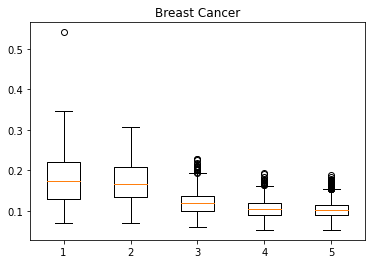

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


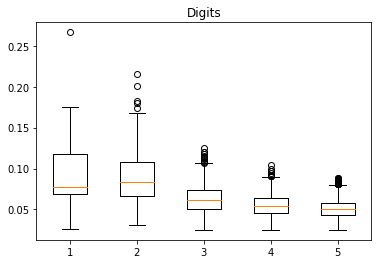

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


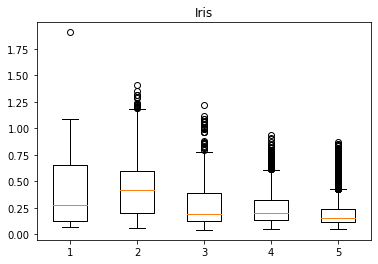

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


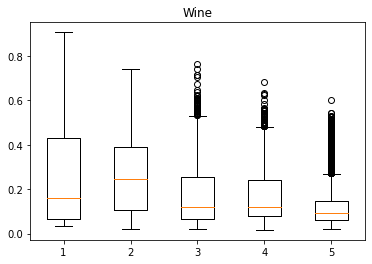

In [26]:
for dataset, dfDataset in df.groupby(['dataset']): 
  boxplots = []
  for k, dfK in dfDataset.groupby(['k']):
    boxplots.append(dfK['errorRate'].values)
  fig, ax = plt.subplots()
  ax.boxplot(boxplots)
  ax.set_title(dataset)
  plt.show()  

### Metrics

#### Mean error rate for ensembles of size <k>

In [ ]:
meanErrorRateSizeK = {}

for dsName in ds_names:
  print()
  for k in range(1,6):
    sum = 0
    ensembles_k = list(filter(lambda res: int(res[1]) == k, filterResultsByDataset(dsName, finalResults)))
    for res in ensembles_k:
      sum += float(res[3])
    errorRate = sum/len(ensembles_k)
    print(f"Mean error rate in ensembles of size {k} in dataset {dsName}: {errorRate}")
    meanErrorRateSizeK[k] = errorRate

print()
for k in range(1,6):
    sum = 0
    ensembles_k = list(filter(lambda res: int(res[1]) == k, finalResults))
    for res in ensembles_k:
      sum += float(res[3])
    errorRate = sum/len(ensembles_k)
    print(f"Mean error rate in ensembles of size {k} in all datasets: {errorRate}")
    meanErrorRateSizeK[k] = errorRate
  

#### For every classifier, the errorRates of ensembles of different size k that contained it

In [30]:
for classifier in list(classifiers.keys()):
  print()
  for k in range(1,6):
    sum = 0
    ensembles_k = list(filter(lambda res: (int(res[1]) == k) and (classifier in str(res[0])), finalResults))
    for res in ensembles_k:
      sum += float(res[3])
    print(f"Mean error rate in ensembles of size {k} that contained {classifier}: {sum/len(ensembles_k)}")



Mean error rate in ensembles of size 1 that contained Linear SVC: 0.1857488050350984
Mean error rate in ensembles of size 2 that contained Linear SVC: 0.23616357632162685
Mean error rate in ensembles of size 3 that contained Linear SVC: 0.15174489598144134
Mean error rate in ensembles of size 4 that contained Linear SVC: 0.1415756124242305
Mean error rate in ensembles of size 5 that contained Linear SVC: 0.1183510801729263

Mean error rate in ensembles of size 1 that contained Decission Tree: 0.194562557601694
Mean error rate in ensembles of size 2 that contained Decission Tree: 0.23575750159112457
Mean error rate in ensembles of size 3 that contained Decission Tree: 0.14393838386656566
Mean error rate in ensembles of size 4 that contained Decission Tree: 0.13230575478684556
Mean error rate in ensembles of size 5 that contained Decission Tree: 0.11227882737706295

Mean error rate in ensembles of size 1 that contained Extra Tree: 0.1553183805375527
Mean error rate in ensembles of size 